In [1]:
# Don't display filter warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import xarray as xr
import os
import glob

## Load data
Model output for each simulation is saved in separate directories as netcdf files.

### List directory structure

In [3]:
# Directory path of model output
#rootdir = '/scratch/gpfs/jt7058/GFDL/fafmip/raw/' # Stellar
rootdir = '/work/noaa/gfdlscr/jkrastin/wmt-inert-tracer/data/raw/fafmip/' # Orion
for fname in sorted(os.listdir(rootdir)):
    print(fname)

CM4_piControl_C
CM4_piControl_C_fafantwater_251
CM4_piControl_C_fafantwater_290
CM4_piControl_C_fafantwater_332
CM4_piControl_C_fafantwaterstress_251
CM4_piControl_C_fafantwaterstress_290
CM4_piControl_C_fafantwaterstress_332
CM4_piControl_C_fafstress_251
CM4_piControl_C_fafstress_290
CM4_piControl_C_fafstress_332
ESM4_piControl_D
ESM4_piControl_D_fafantwater_101
ESM4_piControl_D_fafantwater_151
ESM4_piControl_D_fafantwater_201
ESM4_piControl_D_fafantwaterstress_101
ESM4_piControl_D_fafantwaterstress_151
ESM4_piControl_D_fafantwaterstress_201
ESM4_piControl_D_fafstress_101
ESM4_piControl_D_fafstress_151
ESM4_piControl_D_fafstress_201


### Load ideal age from each run into a common dictionary (`ddict`)

In [4]:
pp = 'ocean_monthly' # pp where static grid file is located
ddict = {s:{} for s in ['CM4','ESM4']}
for mod in ddict:
    
    # Load the static grid data and shelf mask
    if mod == 'CM4':
        subdir = 'CM4_piControl_C'
        grid = xr.open_dataset(rootdir+'CM4_piControl_C/'+pp+'/'+pp+'.static.nc')
        shlf_mask = xr.open_dataset(rootdir[:-11]+'rlb_masks/CM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                        .contour_masked_south.reset_coords(drop=True)
        
    elif mod == 'ESM4':
        subdir = 'ESM4_piControl_D'
        grid = xr.open_dataset(rootdir+'ESM4_piControl_D/'+pp+'/'+pp+'.static.nc')
        shlf_mask = xr.open_dataset(rootdir[:-11]+'rlb_masks/ESM4_1000m_Isobath_Contour_Transport_Masks.nc')\
                        .contour_masked_south.reset_coords(drop=True)
    else:
        print('grid is not available for'+mod)
    
    # Load ideal age data
    ddict_exp = {s:{} for s in ['control','antwater','stress','antwaterstress']}
    for exp in ddict_exp:
        
        if exp == 'control':
            full_path = os.path.join(rootdir,subdir,'ocean_annual_z')
            print('Loading agessc for '+mod+'-'+exp+' in',os.path.basename(subdir))
            ddict_exp[exp] = xr.open_mfdataset(full_path+'/ocean_annual_z.*.agessc.nc',use_cftime=True,
                                   drop_variables=['average_DT','average_T1','average_T2'])
                
        else:
            files = glob.glob(os.path.join(rootdir,subdir+'_faf'+exp+'_*'))
            ddict_mem = {}
            for file in sorted(files):
                full_path = os.path.join(file,'ocean_annual_z')
                print('Loading agessc for '+mod+'-'+exp+'-'+file[-3:]+' in',os.path.basename(file))
                ddict_mem[file[-3:]] = xr.open_mfdataset(full_path+'/ocean_annual_z.*.agessc.nc',use_cftime=True,
                                                         drop_variables=['average_DT','average_T1','average_T2'])
            ddict_exp[exp] = ddict_mem
    
    # Save everything into ddict
    ddict[mod] = ddict_exp
    ddict[mod]['static'] = grid
    ddict[mod]['shlf_mask'] = shlf_mask

Loading agessc for CM4-control in CM4_piControl_C
Loading agessc for CM4-antwater-251 in CM4_piControl_C_fafantwater_251
Loading agessc for CM4-antwater-290 in CM4_piControl_C_fafantwater_290
Loading agessc for CM4-antwater-332 in CM4_piControl_C_fafantwater_332
Loading agessc for CM4-stress-251 in CM4_piControl_C_fafstress_251
Loading agessc for CM4-stress-290 in CM4_piControl_C_fafstress_290
Loading agessc for CM4-stress-332 in CM4_piControl_C_fafstress_332
Loading agessc for CM4-antwaterstress-251 in CM4_piControl_C_fafantwaterstress_251
Loading agessc for CM4-antwaterstress-290 in CM4_piControl_C_fafantwaterstress_290
Loading agessc for CM4-antwaterstress-332 in CM4_piControl_C_fafantwaterstress_332
Loading agessc for ESM4-control in ESM4_piControl_D
Loading agessc for ESM4-antwater-101 in ESM4_piControl_D_fafantwater_101
Loading agessc for ESM4-antwater-151 in ESM4_piControl_D_fafantwater_151
Loading agessc for ESM4-antwater-201 in ESM4_piControl_D_fafantwater_201
Loading agessc f

## Bottom age analysis

In [5]:
def mean_bottom_age(ds,grid,var,depth):
    num = (ds[var]*grid.areacello*grid.wet).where(grid.deptho>depth).sum(dim=['xh','yh'])
    denom = (grid.areacello * grid.wet).where(grid.deptho>depth).sum(dim=['xh','yh'])
    return num/denom

In [6]:
for mod in ddict:
    for exp in list(ddict[mod])[:-2]:
        if exp == 'control':
            
            # Bottom age
            ddict[mod][exp]['bottom_age'] =\
                ddict[mod][exp].agessc.chunk({'time':1}).ffill('z_l').isel(z_l=-1)
            
            # Mean global bottom age below 4000 m
            ddict[mod][exp]['bottom_age_mean'] = \
                mean_bottom_age(ddict[mod][exp],ddict[mod]['static'],'bottom_age',4000)
            
            # Mean bottom age in the Southern Ocean (south of 30S) below 4000 m
            ddict[mod][exp]['bottom_age_mean_so'] = \
                    mean_bottom_age(ddict[mod][exp].sel(yh=slice(None,-30)),
                                    ddict[mod]['static'],'bottom_age',4000)
            
            # Age normalized to global bottom age below 4000 m
            ddict[mod][exp]['age_norm_to_bottom'] = \
                ddict[mod][exp].agessc/ddict[mod][exp].bottom_age_mean
            
            # Age normalized to bottom age in the Southern Ocean below 4000 m
            ddict[mod][exp]['age_norm_to_bottom_so'] = \
                ddict[mod][exp].agessc/ddict[mod][exp].bottom_age_mean_so
            
            # Print summary
            print('\n'+mod+'-'+exp+':','\n','Dimensions:',ddict[mod][exp].dims,'\n',
                  str(ddict[mod][exp].time.values[0])[:10],'to',
                  str(ddict[mod][exp].time.values[-1])[:10]+'\nMax. age at the start and end:',
                  np.round(ddict[mod][exp].isel(time=0).squeeze().agessc.max().values,2),'to',
                  np.round(ddict[mod][exp].isel(time=-1).squeeze().agessc.max().values,2),
                  '\nMean bottom age at the start and end:',
                  np.round(ddict[mod][exp].bottom_age_mean.isel(time=0).values,2),'to',
                  np.round(ddict[mod][exp].bottom_age_mean.isel(time=-1).values,2))
        else:
            for mem in ddict[mod][exp]:
                
                # Bottom age
                ddict[mod][exp][mem]['bottom_age'] =\
                    ddict[mod][exp][mem].agessc.chunk({'time':1}).ffill('z_l').isel(z_l=-1)

                # Mean global bottom age below 4000 m
                ddict[mod][exp][mem]['bottom_age_mean'] = \
                    mean_bottom_age(ddict[mod][exp][mem],ddict[mod]['static'],'bottom_age',4000)
                
                # Mean bottom age in the Southern Ocean (south of 30S) below 4000 m
                ddict[mod][exp][mem]['bottom_age_mean_so'] = \
                    mean_bottom_age(ddict[mod][exp][mem].sel(yh=slice(None,-30)),
                                    ddict[mod]['static'],'bottom_age',4000)
                
                # Age normalized to global bottom age below 4000 m
                ddict[mod][exp][mem]['age_norm_to_bottom'] = \
                    ddict[mod][exp][mem].agessc/ddict[mod][exp][mem].bottom_age_mean
                
                # Age normalized to bottom age in the Southern Ocean below 4000 m
                ddict[mod][exp][mem]['age_norm_to_bottom_so'] = \
                    ddict[mod][exp][mem].agessc/ddict[mod][exp][mem].bottom_age_mean_so
                
                
                # Print summary
                print('\n'+mod+'-'+exp+'-'+mem+':','\n','Dimensions:',ddict[mod][exp][mem].dims,'\n',
                      str(ddict[mod][exp][mem].time.values[0])[:10],'to',
                      str(ddict[mod][exp][mem].time.values[-1])[:10]+'\n Max. age at the start and end:',
                      np.round(ddict[mod][exp][mem].isel(time=0).squeeze().agessc.max().values,2),'to',
                      np.round(ddict[mod][exp][mem].isel(time=-1).squeeze().agessc.max().values,2),
                      '\nMean bottom age at the start and end:',
                      np.round(ddict[mod][exp][mem].bottom_age_mean.isel(time=0).values,2),'to',
                      np.round(ddict[mod][exp][mem].bottom_age_mean.isel(time=-1).values,2))


CM4-control: 
 Dimensions: Frozen(SortedKeysDict({'time': 300, 'z_l': 35, 'yh': 1080, 'xh': 1440, 'nv': 2, 'z_i': 36})) 
 0201-07-02 to 0500-07-02
Max. age at the start and end: 200.5 to 499.32 
Mean bottom age at the start and end: 192.86 to 425.69

CM4-antwater-251: 
 Dimensions: Frozen(SortedKeysDict({'time': 100, 'z_l': 35, 'yh': 1080, 'xh': 1440, 'nv': 2, 'z_i': 36})) 
 0001-07-02 to 0100-07-02
 Max. age at the start and end: 250.5 to 349.49 
Mean bottom age at the start and end: 235.39 to 326.91

CM4-antwater-290: 
 Dimensions: Frozen(SortedKeysDict({'time': 70, 'z_l': 35, 'yh': 1080, 'xh': 1440, 'nv': 2, 'z_i': 36})) 
 0001-07-02 to 0070-07-02
 Max. age at the start and end: 289.5 to 358.49 
Mean bottom age at the start and end: 268.04 to 332.43

CM4-antwater-332: 
 Dimensions: Frozen(SortedKeysDict({'time': 70, 'z_l': 35, 'yh': 1080, 'xh': 1440, 'nv': 2, 'z_i': 36})) 
 0001-07-02 to 0070-07-02
 Max. age at the start and end: 331.49 to 400.47 
Mean bottom age at the start and e

## Calculate bottom age anomaly

In [7]:
# Choose experiment ('antwater', 'stress' or 'antwaterstress')
exp = 'antwaterstress'

# Select variable ('agessc', 'age_norm_to_bottom' or 'age_norm_to_bottom_so')
var = 'age_norm_to_bottom'

bottom_age = {s:{} for s in ddict}
for mod in ddict:
    ds = ddict[mod]['control'].ffill('z_l').isel(z_l=-1)
    
    if mod=='CM4':
        bottom_age_ctrl = ds.sel(time=slice('0281','0380')).mean('time')[var]
    elif mod=='ESM4':
        bottom_age_ctrl = ds.sel(time=slice('0121','0220')).mean('time')[var]
    
    # Esemble mean
    das = []
    for mem in ddict[mod][exp]:
        print(mod+'-'+exp+'-'+mem+':', str(ddict[mod][exp][mem].time.values[0])[:10],
              'to', str(ddict[mod][exp][mem].time.values[-1])[:10])
        if mem=='101':
            print('Different times for ESM4 member 101')
            da = ddict[mod][exp][mem].ffill('z_l').isel(z_l=-1).sel(time=slice('0151','0170')).mean('time')[var]
        else:
            da = ddict[mod][exp][mem].ffill('z_l').isel(z_l=-1).sel(time=slice('0051','0070')).mean('time')[var]
                
        da['member_id'] = mem
        das.append(da)
        
    bottom_age[mod]['mean'] = xr.concat(das, dim='member_id').mean('member_id')
    bottom_age[mod]['anom'] = bottom_age[mod]['mean'] - bottom_age_ctrl

CM4-antwaterstress-251: 0001-07-02 to 0100-07-02
CM4-antwaterstress-290: 0001-07-02 to 0070-07-02
CM4-antwaterstress-332: 0001-07-02 to 0070-07-02
ESM4-antwaterstress-101: 0101-07-02 to 0180-07-02
Different times for ESM4 member 101
ESM4-antwaterstress-151: 0001-07-02 to 0100-07-02
ESM4-antwaterstress-201: 0001-07-02 to 0100-07-02


## Figure 3A: Ensemble-mean bottom age anomaly

In [8]:
from dask.diagnostics import ProgressBar
import cmocean.cm as cmo
import cartopy
import matplotlib.path as mpath
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def get_so_map_boundary():
    '''
    Compute a circle in axes coordinates, which we can use as a boundary
    for the map. We can pan/zoom as much as we like - the boundary will be
    permanently circular.
    '''
    # Parameters for cartopy map
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    return circle

In [10]:
# Load data into memory for plotting
with ProgressBar():
    bottom_age_anom_cm4 = bottom_age['CM4']['anom'].sel(yh=slice(None,-30)).load()
    bottom_age_anom_esm4 = bottom_age['ESM4']['anom'].sel(yh=slice(None,-30)).load()

[########################################] | 100% Completed |  2min 10.1s
[########################################] | 100% Completed | 31.4s


In [11]:
ds_cm4 = bottom_age_anom_cm4.to_dataset(name='bottom_age_diff')
ds_cm4 = ds_cm4.assign_coords({'geolon': ddict['CM4']['static']['geolon'], 
                               'geolat': ddict['CM4']['static']['geolat']})
ds_cm4['shlf_mask'] = ddict['CM4']['shlf_mask']
ds_cm4['deptho'] = ddict['CM4']['static'].deptho

In [12]:
ds_esm = bottom_age_anom_esm4.to_dataset(name='bottom_age_diff')
ds_esm = ds_esm.assign_coords({'geolon': ddict['ESM4']['static']['geolon'], 
                               'geolat': ddict['ESM4']['static']['geolat']})
ds_esm['shlf_mask'] = ddict['ESM4']['shlf_mask']
ds_esm['deptho'] = ddict['ESM4']['static'].deptho

In [13]:
circle = get_so_map_boundary()

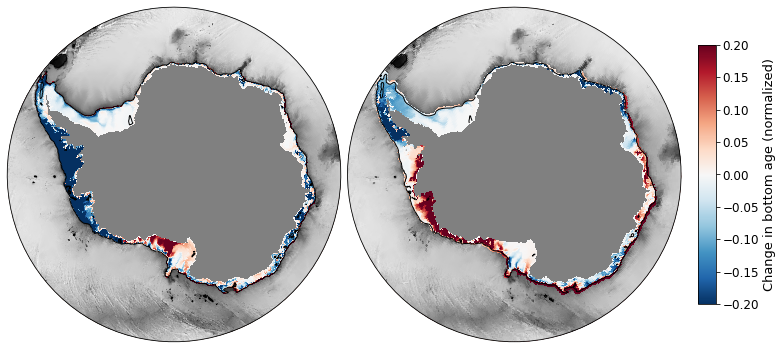

In [14]:
fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(left=0.1, right=0.88, bottom=0.1, top=0.9, hspace=0.1, wspace=0.02)

ax1 = fig.add_subplot(1, 2, 1, projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='gray')
ax1.set_boundary(circle, transform=ax1.transAxes)
ax1.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
p=ds_cm4['bottom_age_diff'].plot(ax=ax1, x='geolon', y='geolat', vmin=-0.2, vmax=0.2, cmap='RdBu_r',
                                       add_labels=False, add_colorbar=False, transform=cartopy.crs.PlateCarree())
ds_cm4.deptho.plot.contour(ax=ax1, x='geolon', y='geolat', levels=[1000.0], linewidths=1, colors='k', 
                           transform=cartopy.crs.PlateCarree(), add_labels=False)
ds_cm4.deptho.where(ds_cm4.shlf_mask!=1).plot(ax=ax1, x='geolon', y='geolat', cmap='Greys_r',add_labels=False, 
                                              add_colorbar=False, transform=cartopy.crs.PlateCarree())

ax2 = fig.add_subplot(1, 2, 2, projection=cartopy.crs.SouthPolarStereo(central_longitude=0.),facecolor='gray')
ax2.set_boundary(circle, transform=ax2.transAxes)
ax2.set_extent([-300, 60, -60, -90], cartopy.crs.PlateCarree())
p=ds_esm['bottom_age_diff'].plot(ax=ax2, x='geolon', y='geolat', vmin=-0.2, vmax=0.2, cmap='RdBu_r',
                                       add_labels=False, add_colorbar=False, transform=cartopy.crs.PlateCarree())
ds_esm.deptho.plot.contour(ax=ax2, x='geolon', y='geolat', levels=[1000.0], linewidths=1, colors='k', 
                           transform=cartopy.crs.PlateCarree(), add_labels=False)
ds_esm.deptho.where(ds_esm.shlf_mask!=1).plot(ax=ax2, x='geolon', y='geolat', cmap='Greys_r',add_labels=False,
                                              add_colorbar=False, transform=cartopy.crs.PlateCarree())

cax = fig.add_axes([0.9, 0.2 , 0.02, 0.6])
cb = fig.colorbar(p, cax=cax, orientation='vertical', shrink=0.5, pad=0.2)
cb.set_label('Change in bottom age (normalized)',fontsize=13)
cb.ax.tick_params(labelsize=12)

plt.savefig('figure.pdf', dpi=None, facecolor='w', edgecolor='w',orientation='portrait', format='pdf', 
            transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()